In [28]:
import pandas as pd
import pickle
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb

In [29]:
with open('data/data.pickle', 'rb') as f:
    df = pickle.load(f)

df = df.astype(float)

In [30]:
# Splitting of the dataset to train-test
X = df.drop('binaryRiskStatus', axis=1)
y = df['binaryRiskStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#### Verification of Stratified splitting

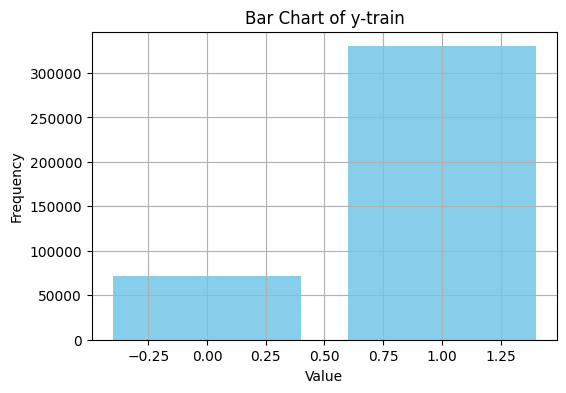

In [31]:
# Target variable frequency in training data
plt.figure(figsize=(6, 4))
value_counts = y_train.value_counts().sort_index()
values = list(value_counts.index)
counts = list(value_counts.values)
plt.bar(values, counts, color='skyblue')
plt.title(f'Bar Chart of y-train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

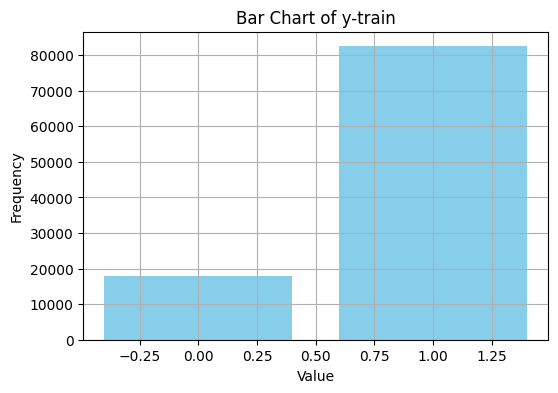

In [32]:
# Target variable frequency in testing data
plt.figure(figsize=(6, 4))
value_counts = y_test.value_counts().sort_index()
values = list(value_counts.index)
counts = list(value_counts.values)
plt.bar(values, counts, color='skyblue')
plt.title(f'Bar Chart of y-train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### LightGBM Model

In [33]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [34]:
params = { 
    'objective': 'binary', 
    'metric': 'auc', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
} 

In [35]:
gbm = lgb.train(
    params, lgb_train, 100, valid_sets=[lgb_eval]
)

[LightGBM] [Info] Number of positive: 329934, number of negative: 71624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 401558, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.821635 -> initscore=1.527462
[LightGBM] [Info] Start training from score 1.527462


In [49]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE of prediction is: {rmse_test}")

The RMSE of prediction is: 0.2781499641636796


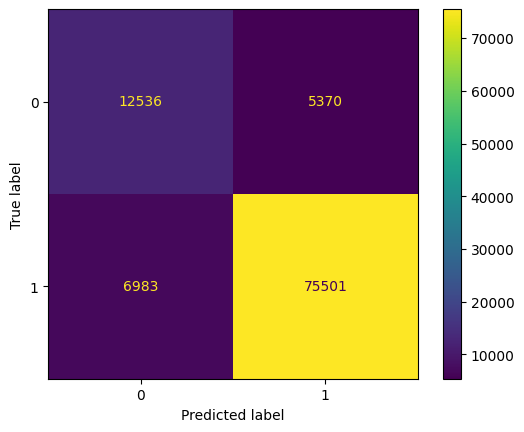

In [50]:
y_pred = [1 if prob > 0.65 else 0 for prob in y_pred]

cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

In [38]:
with open("./model/model.pkl", "wb") as file:
    pickle.dump(gbm, file)